In [1]:
%pip install pandas --quiet
%pip install matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
simulation_params = {
    'test-runs': 5,
    'num-hosts': 20,
    'num-rsu': 1,
    'num-jammer': 1
}

In [4]:
# Load and prepare function for all result files
def load_and_prepare(path, solution, jammer_type):
    df = pd.read_csv(path)
    df['accuracy'] = ((df['tp'] + df['tn']) / (df['tp'] + df['fp'] + df['tn'] + df['fn'])) * 100
    df['jammerType'] = jammer_type
    df['Solution'] = solution
    return df

# Load Durham, UK (static) results
NJS = load_and_prepare('./sumo_static/legacyResults.txt', 'NJS', 'Durham,UK')
NJS_M = load_and_prepare('./sumo_static/results.txt', 'NJS-M', 'Durham,UK')
T_SNR = load_and_prepare('./sumo_static/snrResults.txt', 'T-SNR', 'Durham,UK')
ML_SNR = load_and_prepare('./sumo_static/snrMLResults.txt', 'ML SNR', 'Durham,UK')

# Load Erlangen, DE (proactive) results
NJS_pro = load_and_prepare('./sumo_static/proactiveLegacyResults.txt', 'NJS', 'Erlangen,DE')
NJS_M_pro = load_and_prepare('./sumo_static/proactiveResults.txt', 'NJS-M', 'Erlangen,DE')
T_SNR_pro = load_and_prepare('./sumo_static/proactiveSnrResults.txt', 'T-SNR', 'Erlangen,DE')
ML_SNR_pro = load_and_prepare('./sumo_static/proactiveSnrMLResults.txt', 'ML SNR', 'Erlangen,DE')

# Combine all dataframes
df_combined = pd.concat([
    NJS, NJS_M, T_SNR, ML_SNR,
    NJS_pro, NJS_M_pro, T_SNR_pro, ML_SNR_pro
])

num_runs = df_combined['runName'].nunique()
print(num_runs)
df_combined.head()



5


,runName,time,JLE,tp,fp,tn,fn,accuracy,ttfd,vSpeed,jammerType,Solution,validReportsProcessed
0,1879422756,4.0,85.86081,1,0,3,0,100.0,4.0,NaN,"Durham,UK",NJS,NaN
1,1879422756,6.0,85.86081,1,0,5,0,100.0,4.0,NaN,"Durham,UK",NJS,NaN
2,1879422756,8.0,85.86081,1,0,7,0,100.0,4.0,NaN,"Durham,UK",NJS,NaN
3,1879422756,10.0,89.25990,2,0,8,0,100.0,4.0,NaN,"Durham,UK",NJS,NaN
4,1879422756,12.0,89.25990,2,0,10,0,100.0,4.0,NaN,"Durham,UK",NJS,NaN


Average JLE for Jammer Type 'Durham,UK':
  ML SNR: 67.11658728813559
  NJS: 144.6589466101695
  NJS-M: 68.25400593220338
  T-SNR: 1111.1820379661017
Average JLE for Jammer Type 'Erlangen,DE':
  ML SNR: 230.10350932203391
  NJS: 144.6589466101695
  NJS-M: 41.17049118644067
  T-SNR: 411.7952245762712


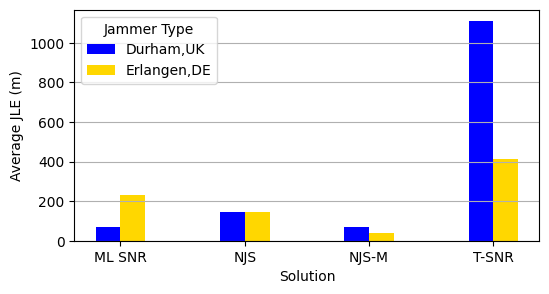

In [5]:
# Group by runName, time, Solution, and jammerType, and compute the mean JLE
df_grouped = df_combined.groupby(['runName', 'time', 'Solution', 'jammerType']).mean().reset_index()

# Pivot the dataframe for easier plotting
df_pivot = df_grouped.pivot_table(values='JLE', index='time', columns=['Solution', 'jammerType'], aggfunc='mean')

plt.figure(figsize=(6, 3))
bar_width = 0.2
solutions = list(df_pivot.columns.levels[0])
jammer_types = list(df_pivot.columns.levels[1])
index = range(len(solutions))

# Define custom colors (extend if needed)
colors = ['blue', 'gold', 'green', 'red']

# Plot bars for each jammer type
for i, jammerType in enumerate(jammer_types):
    means = [df_pivot[(solution, jammerType)].mean() if (solution, jammerType) in df_pivot.columns else 0 for solution in solutions]
    plt.bar([x + i * bar_width for x in index], means, bar_width, label=jammerType, color=colors[i % len(colors)])
    print(f"Average JLE for Jammer Type '{jammerType}':")
    for solution, mean_val in zip(solutions, means):
        print(f"  {solution}: {mean_val}")

plt.xlabel('Solution')
plt.ylabel('Average JLE (m)')
plt.xticks([x + bar_width * (len(jammer_types)-1)/2 for x in index], solutions)
plt.grid(True, axis='y')
plt.legend(title='Jammer Type')
plt.show()

Average ACC for Jammer Type 'Durham,UK':
Solution
ML SNR    36.105292
NJS       96.015639
NJS-M     99.742724
T-SNR     10.414271
dtype: float64
Average ACC for Jammer Type 'Erlangen,DE':
Solution
ML SNR    64.109008
NJS       96.015639
NJS-M     99.482396
T-SNR     12.643337
dtype: float64


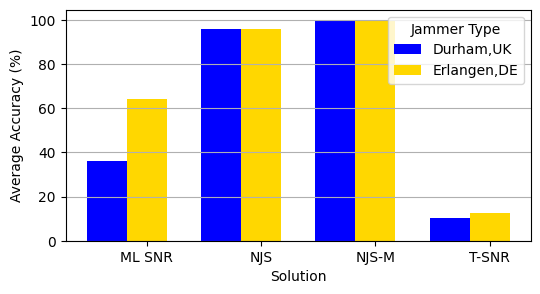

In [6]:
# Group by runName, time, Solution, and jammerType, and compute the mean accuracy
df_grouped = df_combined.groupby(['runName', 'time', 'Solution', 'jammerType']).mean().reset_index()

# Pivot the dataframe for easier plotting
df_pivot = df_grouped.pivot_table(values='accuracy', index='time', columns=['Solution', 'jammerType'], aggfunc='mean')

# Plot the bar chart using df_pivot
plt.figure(figsize=(6, 3))
bar_width = 0.35
index = range(len(df_pivot.columns.levels[0]))

# Define custom colors
colors = ['blue', 'gold']  # Add as many colors as you need

# Plot bars for each jammer type
for i, jammerType in enumerate(df_pivot.columns.levels[1]):
    subset = df_pivot.xs(jammerType, level=1, axis=1)
    plt.bar([x + i * bar_width for x in index], subset.mean(), bar_width, label=jammerType, color=colors[i])
    
    avg_ACC = subset.mean()
    
    # Print the average JLE for each jammer type and solution
    print(f"Average ACC for Jammer Type '{jammerType}':")
    print(avg_ACC)

# Add labels and title
plt.xlabel('Solution')
plt.ylabel('Average Accuracy (%)')
plt.xticks([x + bar_width for x in index], df_pivot.columns.levels[0])
plt.grid(True, axis='y')
plt.legend(title='Jammer Type')

# Show the plot
plt.show()